<a href="https://colab.research.google.com/github/giotre/UIC_2024/blob/main/Invariant_groups_Dittus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature grouping: invariant groups

This notebook demonstrates how to build, train, and evaluate a deep learning model using TensorFlow and Keras. Additionally, we perform a feature grouping analysis to find invariant groups in the form $x_i^{\alpha} x_j^{\beta}$. As case study, we consider the popular Dittus-Boelter equation.

## Setup

We will start by importing the necessary libraries and setting up our environment.

First, we install tensorflow in the version 2.15.

In [ ]:
!pip install tensorflow==2.15

Second, we import all the necessary libraries.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.callbacks import EarlyStopping
import pandas as pd
from scipy import linalg, signal
import tqdm
from scipy.optimize import broyden1, least_squares
from itertools import combinations, product
import pickle
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


## Dataset Creation and Preprocessing

The dataset used in this notebook is assumed to be in an Excel file named 'Dittus.xlsx'.

Such database is created starting from the physical properties of 16 real liquids at ambient temperature and pressure.

Each line of the database contains a value of the flow speed $u$, a value of the pipe diameter $d$, a value of the kinematic viscosity $\nu$, a value of the thermal diffusivity $\kappa$, along with the resulting Nusselt number $\mathrm{Nu}$ according to the Dittus-Boelter equation:

\begin{equation}
\mathrm{Nu} = 0.023 \mathrm{Re}_D^{4/5}\mathrm{Pr}^{2/5}
\end{equation}

with $\mathrm{Re}_D = (ud/\nu)$ and $\mathrm{Pr} = (\nu/\kappa)$, or equivalently

\begin{equation}
\mathrm{Nu} = 0.023\frac{u^{0.8} d^{0.8}}{\nu^{0.4}\kappa^{0.4}}.
\end{equation}

Each fluid accounts for 500 value combinations $u$, $d$, thus accounting for a total of 8,000 samples.

In [ ]:
# Import the data
Data = pd.read_excel('Dittus.xlsx', index_col=0)
Nu = np.array(Data.iloc[:, 4]).astype('float64')


Emulating typical experimental measurements, we add noise on top of the correct target values, sampling 8,000 points $\eta_i$ from a Gaussian distribution, with mean $\mu=0$
 and standard deviation $\sigma=0.1$; the target value of each entry $\mathrm{Nu}_i$ is then multiplied by $(1+\eta_i)$.

In [ ]:
noise = np.random.normal(loc=0.0, scale=0.1, size=len(Nu))  # create Gaussian noise
Nu = Nu * (1 + noise)  # add noise
Data = Data.drop(columns=['Nu']) # drop the original non-noised column
Data.insert(4, 'Nu', Nu) # replace it with the new noised column
Data.to_excel('Dittus Noise.xlsx') # save it in the 'Dittus Noise.xlsx' file

From now onwards, we  consider only the noisy dataset and split it into training (85%) and testing (15%) sets. We also normalize the data with a normalization layer, as it is beneficial for training stability in Deep Neural Networks.


In [ ]:
# Data preprocessing
train_df, test_df = train_test_split(Data, test_size=0.15, random_state=0)
X_train = train_df.iloc[:, :-1]
X_test = test_df[X_train.columns]
y_train = train_df.iloc[:, -1]
y_test = test_df.iloc[:, -1]

# Normalize the data using the normalization layer in TensorFlow
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

## Building and Training the Model

Let's define and compile our deep learning model using Keras and TensorFlow, choosing a validation set as the 15% of the training set (which is 85% of the total).

The deep learning model we consider is a Deep Neural Network (DNN). Our DNN takes the inputs (4-dimensional arrays), normalizes them by means of the normalization layer defined beforehand, and passes to a bunch of hidden layers with a certain number of neurons.

Within each neuron, all the inputs coming from the previous layer are multiplied by the network weights (to be learned), added to the network biases (to be learned), and passed to a non-linear activation function (we choose Rectified Linear Unit -- ReLU). Notice that the non-linearity is necessary, otherwise the entire architecture would result in a trivial linear model.

The structure of a neuron within the first hidden layer (after normalization layer) is like in the following image (from https://www.quora.com/Should-ReLU-be-avoided-for-input-data-that-has-a-lot-of-negative-values-in-machine-learning-models-as-an-activation-function-given-that-ReLU-totally-disregards-negative-values-by-returning-a-zero-output):


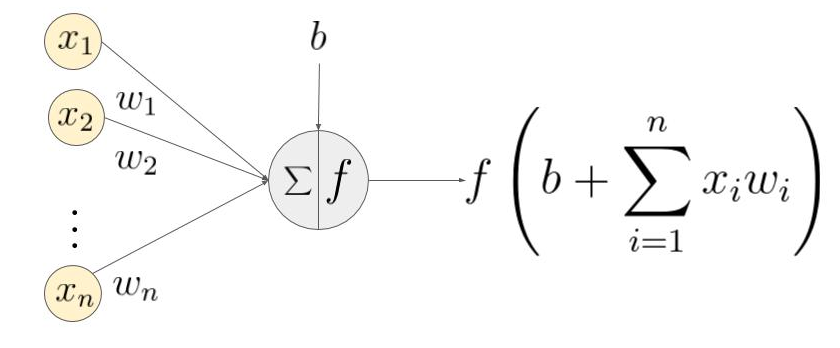

The output layer consists of a single neuron containing the predicted $\mathrm{Nu}_i$ for the $i$th sample of the training set.

The model is trained -- i.e., weights and biases are tuned -- to reduce as more as possible the difference between the known $\mathrm{Nu}_i$ of the training set and the predicted $\mathrm{Nu}_i$ from the model.

We also set up early stopping, i.e., we stop training if there is no improvement in the validation loss after 50 iterations, called "epochs" (see `patience=50`), to prevent overfitting.

We create a checkpoint to save the best model over the training epochs as, by default, the last -- and not the best -- epoch would be saved.

In [ ]:
# Define the model
def build_and_compile_model(norm):
    model = Sequential([
        norm,                                  # normalization layer defined beforehand
        Dense(128, activation='relu'),         # layer with 128 neurons and relu activation function
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation='linear')          # output layer
    ])

    model.compile(loss='mean_absolute_error', optimizer=Adam(0.001))
    return model

# Callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

checkpoint_filepath = './tmp/checkpoint_dittus.tf'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

model = build_and_compile_model(normalizer)

# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_split=0.15,
    verbose=2,
    epochs=500,
    callbacks=[es, model_checkpoint_callback]
)

# Save the model history
with open('DittusHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)


## Evaluating the Model

After training the model, we load the best weights and evaluate the model's performance on the test set.


We compare the real value of the $\mathrm{Nu}$ over testing set, with the corresponding values predicted by the trained model.
We check those performances by means of three measures:
* coefficient of determination $R^2$, defined as
\begin{equation}
R^2(\mathbf{y}, {\mathbf{\hat{y}}}) = 1-\frac{\sum_{i=1}^k(y_i-\hat{y_i})^2}{\sum_{i=1}^k(y_i-\overline{y})^2}
\end{equation}
where $\mathbf{y}$ is the $k-$dimensional vector of real values, $\mathbf{\hat{y}}$ is the $k-$dimensional vector of predicted values, $\overline{y}=k^{-1}∑_{i=1}^ky_i$ is the average over real values. $R^2= 1$ if the prediction is perfect (i.e., all the red dots are on the blue line, with $y_i=\hat{y_i}, \forall i\in[1,\dots, k]$).

* Mean Absolute Error $\mathrm{MAE}$, defined as
\begin{equation}
\mathrm{MAE}(\mathbf{y}, {\mathbf{\hat{y}}}) = \frac{1}{k}\sum_{i=1}^k|y_i - \hat{y_i}|
\end{equation}
with the same meaning of the notation.

* Root Mean Squared Error $\mathrm{RMSE}$
\begin{equation}
\mathrm{RMSE}(\mathbf{y}, {\mathbf{\hat{y}}}) = \left(\frac{1}{k}\sum_{i=1}^k(y_i - \hat{y_i})^2 \right)^{1/2}
\end{equation}
with the same meaning of the notation.

In our case, $k$ is the length (i.e., the number of rows) of the testing set.


The second figure represents the behaviour of the training loss (blue) and of the validation loss (orange) over the training epochs.

In [ ]:
# Load saved weights (best model)
model.load_weights(checkpoint_filepath)
model.save('dittus_model.tf')

# Load the model history
with open('DittusHistoryDict', "rb") as file_pi:
    history = pickle.load(file_pi)

# Make predictions on the test set
test_predictions = model.predict(X_test).flatten()
test_labels = y_test.values

# Calculate evaluation metrics
r2 = r2_score(test_labels, test_predictions)
mae = mean_absolute_error(test_labels, test_predictions)
rmse = np.sqrt(mean_squared_error(test_labels, test_predictions))

# Plot the results
delta = max(test_labels) - min(test_labels)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.1, 3), dpi=190)
ax1.scatter(test_labels, test_predictions, c="crimson", alpha=0.2)
p1 = max(max(test_predictions), max(test_labels))
p2 = min(min(test_predictions), min(test_labels))
ax1.plot([p1, p2], [p1, p2], "b-")
ax1.annotate("$R^2$ = %0.3f" % r2, xy=(0.02 * delta, 0.95 * delta), xytext=(0.02 * delta, 0.95 * delta))
ax1.annotate("MAE = %0.2f" % mae, xy=(0.02 * delta, 0.85 * delta), xytext=(0.02 * delta, 0.85 * delta))
ax1.annotate("RMSE = %0.2f" % rmse, xy=(0.02 * delta, 0.75 * delta), xytext=(0.02 * delta, 0.75 * delta))
ax1.set_xlabel(r"True $\overline{\rm{Nu}}$")
ax1.set_ylabel(r"Predicted $\overline{\rm{Nu}}$")

ax2.plot(history['loss'], label='loss')
ax2.plot(history['val_loss'], label='validation loss')
ax2.set_yscale('log')

ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE')
ax2.legend(frameon = False)
plt.subplots_adjust(wspace=0.5)


plt.savefig('dittus_model.svg', bbox_inches='tight')

plt.show()


### Feature Grouping Analysis

This section performs feature grouping analysis using combinations of two and three features.

The analysis aims to detect invariant groups of features in the form $x_i^{\alpha}x_j^{\beta}$.

In [ ]:
# Load the pre-trained model
model = tf.keras.models.load_model('dittus_model.tf')  # load saved model

# List of features
other_columns = X_train.columns

# Function to calculate orthogonal vector in the null space of B
def univec(a, b, x0, index_1, index_2):
    B = np.zeros((1, 2))
    B[0][0] = a / x0[index_1]
    B[0][1] = b / x0[index_2]  # build the matrix B in x0
    un_norm = linalg.null_space(B)  # ortho-normal basis in the null-space of B

    return un_norm

# Function to select random points within feature ranges
def delta(l, Data, i):
    x_1_min = np.min(Data[l[i][0]])
    x_1_max = np.max(Data[l[i][0]])
    x_2_min = np.min(Data[l[i][1]])
    x_2_max = np.max(Data[l[i][1]])
    return(x_1_min, x_1_max, x_2_min, x_2_max)

# Generate all possible combinations of two features
l = list(combinations(list(other_columns), 2))

N = 20  # number of points evaluated per iteration
repeat = 3  # number of iterations
A = np.zeros([len(l), N])
B = np.zeros([len(l), N])

# Analyze each pair of features
for i in tqdm.tqdm(range(len(l))):
    a = 0.5 * np.ones(N)  # initial guesses for first iteration
    b = -0.5 * np.ones(N)

    for j in range(repeat):
        beta = np.array([np.mean(a), np.mean(b)])  # initial guess for successive iterations

        a = np.ones(N)
        b = np.ones(N)

        for k in range(N):

            # pick two random numbers
            w1 = np.random.uniform(0, 1)
            w2 = np.random.uniform(0, 1)

            # compute the mean of each feature
            tx = Data[other_columns].describe().loc['mean']

            # compute the x_1_min, x_1_max, x_2_min, x_2_max for the i-th couple of features
            delta_values = delta(l, Data, i)

            index_1 = pd.DataFrame(tx, columns=other_columns).columns.get_loc(l[i][0])  # get index of the first feature
            index_2 = pd.DataFrame(tx, columns=other_columns).columns.get_loc(l[i][1])  # get index of the second feature

            def MAIN(beta):

                # initial guess
                a0 = beta[0]
                b0 = beta[1]

                tx = Data[other_columns].describe().loc['mean']  # set feature values to their average
                r = delta_values[0] + w1 * (delta_values[1] - delta_values[0])  # pick the value of the first feature at random in the interval x1_min, x1_max
                tx[l[i][0]] = r  # set the value of the x0 component corresponding to the first feature in the couple equal to r
                s = delta_values[2] + w2 * (delta_values[3] - delta_values[2]) #do the same for the second feature
                tx[l[i][1]] = s
                x0 = tf.constant(tx)

                with tf.GradientTape(persistent=True) as tape:
                    tape.watch(x0)
                    preds1 = model(x0)  # compute the DNN model in x0
                dy_dx1 = tape.gradient(preds1, x0)[index_1]  # evaluate the partial derivative of the model in x0 with respect to the first feature

                with tf.GradientTape(persistent=True) as tape:
                    tape.watch(x0)
                    preds2 = model(x0) # compute the DNN model in x0
                dy_dx2 = tape.gradient(preds2, x0)[index_2] # evaluate the partial derivative of the model in x0 with respect to the second feature

                grad1 = dy_dx1.numpy()  # convert from tensor to numpy array
                grad2 = dy_dx2.numpy()  # convert from tensor to numpy array

                der = np.array([grad1, grad2])  # create derivative vector which has to be parallel to the orthogonal vector un in x0
                der = der / np.sqrt(der[0] ** 2 + der[1] ** 2)  # normalization

                tx = Data[other_columns].describe().loc['mean']  # need to create x0 again, so set features to average
                tx[l[i][0]] = r  # set the value of the x0 component corresponding to the first feature in the couple equal to r
                tx[l[i][1]] = s  # set the value of the x0 component corresponding to the second feature in the couple equal to r
                x0 = tf.constant(tx)  # create x0

                un = univec(a0, b0, x0.numpy(), index_1, index_2)  # get un to check for the condition of invariance (components of the gradient aligned with un in x0)
                DIFF = np.array([np.dot(der, un)[0], a0 ** 2 + b0 ** 2 - 1], dtype=float)  # evaluate the residual

                return DIFF

            # Optimize to find the best fit for a and b
            x = least_squares(MAIN, beta, method='trf', ftol=2.3e-16, verbose=1, max_nfev=50)

            '''
            Notice that x is not a variable, but rather a scipy.optimize._optimize.OptimizeResult object (check it by running type(x)).
            Its x-th attribute -- x.x -- is the 2-dimensional variable we are looking for, containing the optimal [alpha, beta].
            '''
            x.x = x.x / np.linalg.norm(x.x)

            a[k] = x.x[0]  # save the results for each iteration
            b[k] = x.x[1]

    A[i] = a  # create matrix with the results
    B[i] = b


In [ ]:
# Create a dataframe to summarize mean and standard deviation of the results
a_b = np.array([np.mean(A, axis=1), np.std(A, axis=1), np.mean(B, axis=1), np.std(B, axis=1)]).transpose()
a_b_frame = pd.DataFrame(a_b, columns=['mean alpha', 'std alpha', 'mean beta', 'std beta'], index=l)
a_b_frame

For all the six possible couples, check

* If the std of either $\alpha$ or $\beta$ is too high w.r.t. the mean. If so, the group is not found.

* If the mean of either $\alpha$ or $\beta$ is too near to 0. If so, this kills the group.


These are not our cases, where all groups are found. However, notice that those groups consist of normalized coefficients, and not of the real physical coefficients of the Dittus-Boelter equation.

In [ ]:
# Scatter plots for feature pairs
for ind in range(len(A)):
    plt.figure(figsize=(6, 3), dpi=300)
    plt.scatter(np.arange(N), A[ind], label=r'$\alpha$')
    plt.scatter(np.arange(N), B[ind], label=r'$\beta$')
    plt.title(l[ind])
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.ylim(-1, 1)
    plt.show()